In [1]:
import sys
sys.path.append('gym-unbalanced-disk/gym_unbalanced_disk/')
import gym_unbalanced_disk, time, gym.wrappers
from matplotlib import pyplot as plt
import os
import numpy as np
import torch

from DQNfunctions import Qfunction, DQN_rollout, show, eval_Q, save_Qfunction, load_Qfunction

In [2]:
# Indicate whether to train Qfunction or to load existing Qfunction for analysis
Train_Qfunction = False

# Decide file name for either saving or loading and whether to save Q function and plots
fileNameLoad = 'QfunctionFinal.pt'
fileNameSave = 'QfunctionFinal.pt'
Save = True

# Choose reward function either for training or evaluation
target_angle = np.pi # target set to be balanced on top

angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.01*(((np.sin(self.th - np.pi/2)+1)/2)*(self.u)**2)

reward_function = lambda self: angle_reward(self) + correctVelocity_reward(self) + voltage_penalty(self)

In [3]:
# This will only run for training, change variables as you please for training
if Train_Qfunction:
    max_episode_steps = 250
    env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
    env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

    env.change_reward_function(reward_function)

    env.set_discrete_values_manual([-3.0, -1.5, -0.9, -0.35, 0, 0.35, 0.9, 1.5, 3.0])

    # These settings can be changed for training
    gamma = 0.98 #f=)
    batch_size = 256 #f=)
    N_iterations = 26 #f=)
    N_rollout = 50000 #f=)
    N_epochs = 20 #f=)
    N_evals = 5 #f=)
    lr = 0.0005 #given

    assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
    Q = Qfunction(env)
    optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
    DQN_rollout(Q, optimizer, env, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
                N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)
    save_Qfunction(Q, fileNameSave)

In [4]:
#This will only run if Q function is loaded in.
# WARNING: The discrete values should be the same as in the original run to be able to run the loaded Qfunction.
# WARNING: The reward function should be the same as in the original run to be able to asses the loaded Qfunction.
if not Train_Qfunction:
    max_episode_steps = 250
    env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
    env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
    
    env.set_discrete_values_manual([-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0])
    
    env.change_reward_function(reward_function)
    
    Q = load_Qfunction(env, fileNameLoad)

Running from folder
Discrete value set changed to [-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0]


In [5]:
u,theta,omega,rewards = show(Q, env)

pygame 2.4.0 (SDL 2.26.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


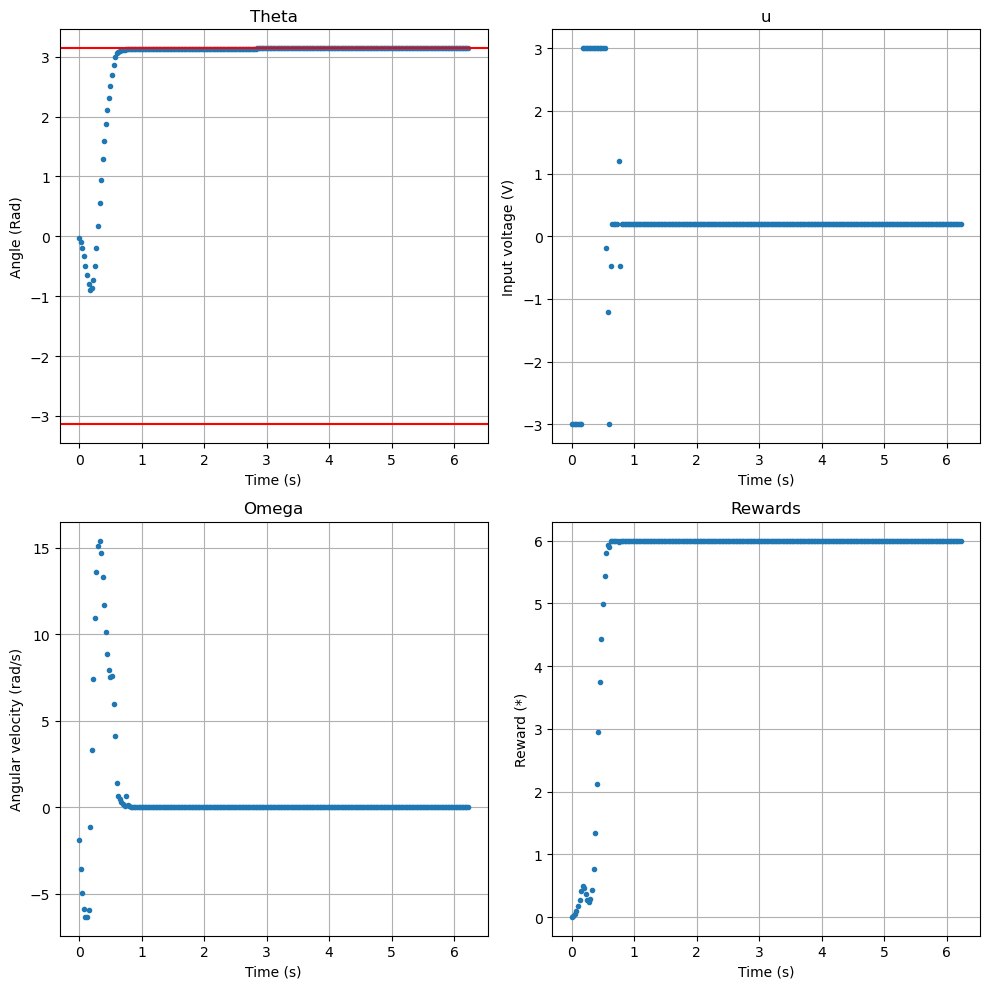

In [6]:
# Create a figure with three subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot theta
axs[0,0].plot([i*env.dt for i in range(max_episode_steps)], theta, '.')
axs[0,0].set_title('Theta')
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Angle (Rad)')
axs[0,0].axhline(y=target_angle, color='r', linestyle='-')
axs[0,0].axhline(y=-target_angle, color='r', linestyle='-')
axs[0,0].grid(True)

# Plot u
axs[0,1].plot([i*env.dt for i in range(max_episode_steps)], u, '.')
axs[0,1].set_title('u')
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_ylabel('Input voltage (V)')
axs[0,1].grid(True)

# Plot omega
axs[1,0].plot([i*env.dt for i in range(max_episode_steps)], omega, '.')
axs[1,0].set_title('Omega')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Angular velocity (rad/s)')
axs[1,0].grid(True)

# Plot omega
axs[1,1].plot([i*env.dt for i in range(max_episode_steps)], rewards, '.')
axs[1,1].set_title('Rewards')
axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylabel('Reward (*)')
axs[1,1].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

if Save:
    ROOT_DIR = os.path.dirname('')
    fig.savefig(os.path.realpath(os.path.join(ROOT_DIR, os.path.splitext(fileNameSave)[0]+'FigureSimulation.eps')), format='eps', bbox_inches='tight')
    fig.savefig(os.path.realpath(os.path.join(ROOT_DIR, os.path.splitext(fileNameSave)[0]+'FigureSimulation.svg')),bbox_inches='tight')
    if Train_Qfunction:
        save_Qfunction(Q, fileNameSave)

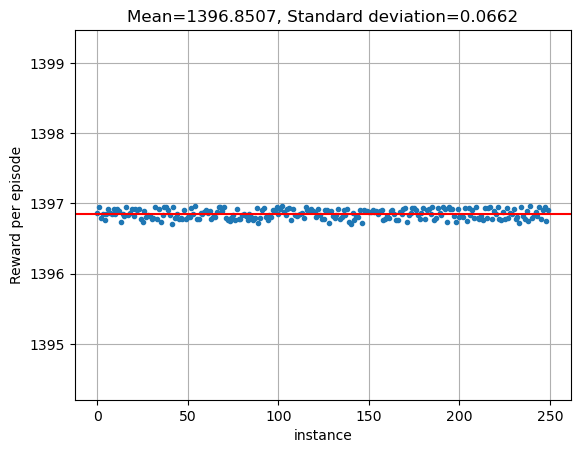

In [7]:
from matplotlib import pyplot as plt
Rewards = [eval_Q(Q,env) for i in range(250)]
plt.plot(Rewards,'.')
plt.title(f'Mean={np.mean(Rewards):.4f}, Standard deviation={np.std(Rewards):.4f}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.ylim(np.min(Rewards)-2.5, np.max(Rewards)+2.5)
plt.axhline(y=np.mean(Rewards), color='r', linestyle='-')
plt.grid(True)
# plt.show()

if Save:
    ROOT_DIR = os.path.dirname('')
    plt.savefig(os.path.realpath(os.path.join(ROOT_DIR, os.path.splitext(fileNameSave)[0]+'Evaluation.eps')), format='eps', bbox_inches='tight')
    plt.savefig(os.path.realpath(os.path.join(ROOT_DIR, os.path.splitext(fileNameSave)[0]+'Evaluation.svg')), bbox_inches='tight')